# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from os import rename
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, GRU, Dropout, BatchNormalization, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install keras-visualizer
from tensorflow.keras.utils import plot_model

# Functions

The following functions were created to make our code resuable and clean up the work that we do for each model. Since the majority of our code stays the same and we are tweaking the architecture, the next few blocks simply everthing.
1. The price_sequences function groups days by 5 (or whatever increment you would like to investigate). This allows the model to look at multiple days at a time. It also properly shapes the data that the model needs.
2. The news_sequences function aims to group news articles into sequences based on a specified time window (time_steps), which defaults to 5 days. Essentially, it's creating chunks of news text, where each chunk contains the news from a consecutive number of days. This is useful for time-series analysis, allowing the model to learn from the flow of news information over time.
3. The create_train_val_test_df function creates our train, validation, and test groups based on the date ranges that we specify.
4. The create_price_sequences and create_news_sequences are doing the same as the original price and news sequences functions, but since we have slightly different models, we have slightly different setup functions.

In [ ]:
def price_sequences(df, ticker, time_steps=5, feature_cols=['Close', 'High', 'Low', 'Open'], feature_scaler=None, target_scaler=None, target_column='Close'):
    # Filter for one ticker
    company_df = df[df['Company'] == ticker].sort_values('Date')

    # Extract feature data
    features = company_df[feature_cols].values

    # Apply scaling if a scaler is provided
    if feature_scaler is not None:
        features = feature_scaler.transform(features)

    X, y = [], []

    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(features[i + time_steps][0])

    return np.array(X), np.array(y)


    # Filter for one ticker and sort by date
    company_df = df[df['Company'] == ticker].sort_values('Date')

    # Extract and scale features
    features = company_df[feature_cols].values

    if feature_scaler is not None:
        features = feature_scaler.transform(features)

    # Extract and optionally scale the target column
    target_values = company_df[[target_column]].values  # shape: (n_samples, 1)

    if target_scaler is not None:
        target_values = target_scaler.transform(target_values)

    X, y = [], []

    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target_values[i + time_steps][0])  # Scaled target

    return np.array(X), np.array(y)

In [ ]:
def news_sequences(news_df, time_steps=5):
    grouped_sequences = []
    tickers = news_df['Company'].unique()

    for ticker in tickers:
        df = news_df[news_df['Company'] == ticker].sort_values('Date')
        texts = df['body_clean'].tolist()
        dates = df['Date'].tolist()

        for i in range(len(df) - time_steps):
            sequence = texts[i:i+time_steps]
            flat_sequence = ' '.join([text if isinstance(text, str) else ' '.join(text) for text in sequence])
            grouped_sequences.append(flat_sequence)

    return grouped_sequences

In [ ]:
def create_train_val_test_df (df, start_date = '2023-01-01', train_date = '2023-12-31', validation_date = ['2024-01-01', '2024-06-30'], test_date = '2024-07-01', end_date='2024-12-31'):

    df_train = df[(df['Date'] >= start_date) & (df['Date'] <= train_date)].reset_index(drop=True)
    df_val = df[(df['Date'] >= validation_date[0]) & (df['Date'] <= validation_date[1])].reset_index(drop=True)
    df_test = df[(df['Date'] >= test_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    return df_train, df_val, df_test

In [ ]:
def create_price_sequences(
    df,
    time_steps=5,
    target_offset=1,
    target_length=1,
    feature_cols=['Close', 'High', 'Low', 'Open', 'Volume'],
    target_column='Close',
    feature_scaler=None,
    target_scaler=None
):
    """
    df: Pandas DataFrame with stock data
    time_steps: How many days of history to use for each input
    target_offset: How many days ahead to start the prediction
    target_length: How many days to predict
    feature_cols: Features to use in X
    target_column: Column to predict
    feature_scaler: StandardScaler for feature columns
    target_scaler: StandardScaler for 'Close' column (target)
    """

    df = df.sort_values('Date').reset_index(drop=True)

    # Store unscaled Close values for target use
    unscaled_close = df[target_column].values.reshape(-1, 1)

    # Prepare feature data
    features = df[feature_cols].values
    if feature_scaler is not None:
        features = feature_scaler.transform(features)

    X, y = [], []

    for i in range(len(features) - time_steps - target_offset - target_length + 1):
        # Sequence of features for input
        X.append(features[i:i + time_steps])

        # Use unscaled 'Close' values for target
        start = i + time_steps + target_offset - 1
        end = start + target_length
        close_target = unscaled_close[start:end]  # (target_length, 1)

        if target_scaler is not None:
            close_target = target_scaler.transform(close_target)

        y.append(close_target.flatten())  # (target_length,)

    return np.array(X), np.array(y)

Example Usage:

Predict the next day's price (default behavior):

```
X, y = create_price_sequences(df)
```
Predict the price 3 days ahead (single point):

```
X, y = create_price_sequences(df, time_steps=5, target_offset=3, target_length=1)
```
Predict the next 5 days of prices (multi-output):

```
X, y = create_price_sequences(df, time_steps=10, target_offset=1, target_length=5)
```

Now y.shape = (samples, 5) — good for multi-output regression

In [ ]:
def create_news_sequences(news_df, time_steps=5):
    grouped_sequences = []
    tickers = news_df['matched_company'].unique()

    for ticker in tickers:
        df = news_df[news_df['matched_company'] == ticker].sort_values('Date_day')
        texts = df['body'].tolist()
        dates = df['Date_day'].tolist()

        for i in range(len(df) - time_steps):
            # Get time_steps worth of news
            sequence = texts[i:i+time_steps]
            # Flatten and join the texts
            flat_sequence = ' '.join([text if isinstance(text, str) else ' '.join(text) for text in sequence])
            grouped_sequences.append(flat_sequence)

    return grouped_sequences

# Loading Data

In [ ]:
# Loading the stock data
stocks = pd.read_csv('https://drive.google.com/uc?export=download&id=1meoD-PkTGioNxpm8ZrIwZelJpvNsce4g', header=[0, 1], index_col=0)

In [ ]:
# Loading the text data
text =  pd.read_csv('https://drive.google.com/uc?export=download&id=1baRjD8lUAf7NUTlCiSZSQJ37jwGrhQ74').drop(columns=['is_real'])

In [ ]:
# Loading a pretrained dataset, with the sentiment labels from FinBERT
news_df_bert = pd.read_csv('https://drive.google.com/uc?export=download&id=1Kgc9JrNf0JrG4AUWMQIeY2XnfAgphUIU')

# Preprocessing and Understanding the Data

Financial numerical and textual data need some processing before being used in our final model. Some preprocessing steps, such as modifying the table's multi-index, filtering the dates and renaming the columns, were carried out to ensure standardization of our input data. The following code segments depict how the stock information was processed as well as the text data.

We wanted to note that the descriptive statistics for our data will not provide much context or insight into the problem itself. There is not much to look into in terms of the stock prices as that is just the raw data, similarly with the text. We would agree that these would be beneficial if we were including additional financial metrics that were helping our prediction

## Stocks Data

In [ ]:
# Changing the data structure from the "yfinance" scrap
df_long = stocks.stack(level=1).reset_index()
df_long.rename(columns={"level_1": "Ticker"}, inplace=True)

selected_cols = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
df_stocks_final = df_long[selected_cols]

In [ ]:
# Filtering the dates (only stock data from 2023 to 2024)
df_stocks_final = df_stocks_final[(df_stocks_final['Date'] >= '2023-01-01') & (df_stocks_final['Date'] <= '2024-12-31')].reset_index(drop=True)

In [ ]:
# Change data type (ensuring it is a datetime column)
df_stocks_final['Date'] = pd.to_datetime(df_stocks_final['Date'])

In [ ]:
# Changing company names (from ticker to actual company name)
ticker_to_company = {
    'AAPL': 'Apple',
    'AMZN': 'Amazon',
    'GOOG': 'Alphabet',
    'META': 'Meta',
    'MSFT': 'Microsoft',
    'NVDA': 'NVIDIA',
    'TSLA': 'Tesla'
}

df_stocks_final['Ticker'] = df_stocks_final['Ticker'].map(ticker_to_company)

In [ ]:
# Change column name
df_stocks_final = df_stocks_final.rename(columns={'Ticker': 'Company'})

In [ ]:
df_stocks_final.head()

Price,Date,Company,Open,High,Low,Close,Volume
0,2023-01-03,Apple,128.782657,129.395526,122.742880,123.632538,112117500
1,2023-01-03,Amazon,85.459999,86.959999,84.209999,85.820000,76706000
2,2023-01-03,Alphabet,89.406537,91.118430,88.600351,89.277145,20738500
3,2023-01-03,Meta,122.243862,125.777212,121.706394,124.154854,35528500
4,2023-01-03,Microsoft,238.676649,241.298281,233.099534,235.240051,25740000


In [ ]:
# Filtering the final stock dataframe for each company we have in our dataset
df_apple = df_stocks_final[df_stocks_final['Company']=='Apple']
df_amazon = df_stocks_final[df_stocks_final['Company']=='Amazon']
df_alphabet = df_stocks_final[df_stocks_final['Company']=='Alphabet']
df_meta = df_stocks_final[df_stocks_final['Company']=='Meta']
df_microsoft = df_stocks_final[df_stocks_final['Company']=='Microsoft']
df_nvidia = df_stocks_final[df_stocks_final['Company']=='NVIDIA']
df_tesla = df_stocks_final[df_stocks_final['Company']=='Tesla']

In [ ]:
# Another option of table structure, in which we have all stocks information for all companies in each row
pivot_df = df_stocks_final.drop(columns='Volume').pivot(index='Date', columns='Company')

pivot_df.columns = [f"{col[0].lower()}_{col[1].lower()}" for col in pivot_df.columns]

pivot_df = pivot_df.reset_index()

pivot_df.head()

,Date,open_alphabet,open_amazon,open_apple,open_meta,open_microsoft,open_nvidia,open_tesla,high_alphabet,high_amazon,...,low_microsoft,low_nvidia,low_tesla,close_alphabet,close_amazon,close_apple,close_meta,close_microsoft,close_nvidia,close_tesla
0,2023-01-03,89.406537,85.459999,128.782657,122.243862,238.676649,14.838841,118.470001,91.118430,86.959999,...,233.099534,14.084459,104.639999,89.277145,85.820000,123.632538,124.154854,235.240051,14.303280,108.099998
1,2023-01-04,90.580970,86.550003,125.431607,126.782470,228.072278,14.555074,109.110001,90.809881,86.980003,...,221.866771,14.229341,107.519997,88.291809,85.139999,124.907700,126.772522,224.949890,14.736924,113.639999
2,2023-01-05,87.654829,85.330002,125.668849,125.538338,223.084300,14.479135,110.510002,87.794168,85.419998,...,217.742843,14.136416,107.160004,86.360954,83.120003,123.583099,126.344543,218.282883,14.253321,110.339996
3,2023-01-06,86.948168,83.029999,124.561732,128.365002,218.960392,14.462150,103.000000,88.052936,86.400002,...,215.376517,14.022511,101.809998,87.744400,86.080002,128.130234,129.410080,220.855423,14.846835,113.059998
4,2023-01-09,88.774520,87.459999,128.970489,130.544730,222.347876,15.271487,118.959999,90.401815,89.480003,...,222.308607,15.128603,117.110001,88.381386,87.360001,128.654160,128.862656,223.005737,15.615205,119.769997


## Text Data

In [ ]:
# Ensure the 'Date_day' column in `text` is in the correct datetime format
text['Date_day'] = pd.to_datetime(text['Date_day'])

# Merge the news and stock data on the date to keep only the same dates in both dataframes
text_filtered_days = pd.merge(text, df_stocks_final[['Date', 'Company']], how='inner', left_on=['Date_day', 'matched_company'], right_on=['Date', 'Company'])
text_filtered_days = text_filtered_days.drop(columns=['Date', 'Company'])

In [ ]:
# Changing columns names
text_filtered_days = text_filtered_days.rename(columns={'matched_company': 'Company'})
text_filtered_days = text_filtered_days.rename(columns={'Date_day': 'Date'})

In [ ]:
text_filtered_days.head()

,Company,Date,Tone,PositiveScore,NegativeScore,Polarity,ActivityRefDensity,SelfGroupRefDensity,body_clean
0,Alphabet,2023-01-03,1.589595,1.66185,0.072254,1.734104,16.907514,0.939306,"Given high inflation, the Federal Reserve has ..."
1,Alphabet,2023-01-04,1.589595,1.66185,0.072254,1.734104,16.907514,0.939306,"Given high inflation, the Federal Reserve has ..."
2,Alphabet,2023-01-05,1.589595,1.66185,0.072254,1.734104,16.907514,0.939306,"Given high inflation, the Federal Reserve has ..."
3,Alphabet,2023-01-06,1.589595,1.66185,0.072254,1.734104,16.907514,0.939306,"Given high inflation, the Federal Reserve has ..."
4,Alphabet,2023-01-09,1.589595,1.66185,0.072254,1.734104,16.907514,0.939306,"Given high inflation, the Federal Reserve has ..."


In [ ]:
# Filtering the final text dataframe for each company we have in our dataset
text_apple = text_filtered_days[text_filtered_days['Company']=='Apple']
text_amazon = text_filtered_days[text_filtered_days['Company']=='Amazon']
text_alphabet = text_filtered_days[text_filtered_days['Company']=='Alphabet']
text_meta = text_filtered_days[text_filtered_days['Company']=='Meta']
text_microsoft = text_filtered_days[text_filtered_days['Company']=='Microsoft']
text_nvidia = text_filtered_days[text_filtered_days['Company']=='NVIDIA']
text_tesla = text_filtered_days[text_filtered_days['Company']=='Tesla']

# Models

## Naive Model

First, we tried to create a baseline model so that we could use it for comparison with our neural network models. For this, we chose a Naive Bayes model that basically predicts the next day based on the data from the previous day.

In [ ]:
def naive_model(df):
    # Ensure chronological order
    df = df.sort_values('Date')

    # Target: Next day's closing price
    df['next_day_close'] = df['Close'].shift(-1)

    # Naïve prediction: today's close is the prediction for tomorrow
    df['naive_pred'] = df['Close']

    # Drop last row (no next_day_close available)
    df = df.dropna(subset=['next_day_close'])

    # Split data (adjust dates for your dataset)
    train = df[df['Date'] < '2024-01-01']
    val = df[(df['Date'] >= '2024-01-01') & (df['Date'] <= '2024-06-30')]
    test = df[df['Date'] >= '2024-07-01']

    # Split the data into the same train, val, and test increments that we use throughout
    train = train.dropna(subset=['next_day_close'])
    val = val.dropna(subset=['next_day_close'])
    test = test.dropna(subset=['next_day_close'])

    return train, val, test

# Calculate the different metrics so that we can compar the future models on multuple levels
def evaluate_regression(split, name):
    mae = mean_absolute_error(split['next_day_close'], split['naive_pred'])
    rmse = np.sqrt(mean_squared_error(split['next_day_close'], split['naive_pred']))
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Graphically deisplay the model
def plot_predictions(test):
    plt.figure(figsize=(12, 4))
    plt.plot(test['Date'], test['next_day_close'], label='Actual Close', marker='o')
    plt.plot(test['Date'], test['naive_pred'], label='Naïve Prediction', marker='x')
    plt.legend()
    plt.title('Naïve Predictor vs. Actual Close (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.show()

Test - MAE: 9.2176, RMSE: 12.6401


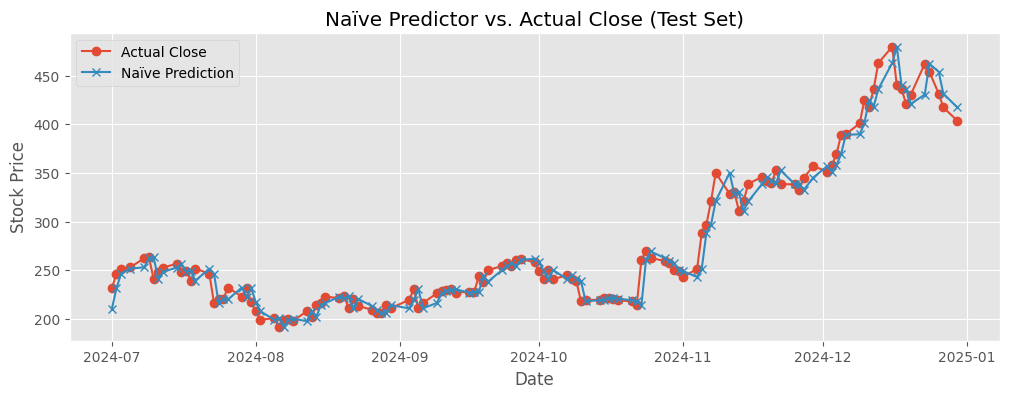

In [ ]:
# Run model
train, val, test = naive_model(df_tesla)

# Evaluate
evaluate_regression(test, 'Test')

# Visualize
plot_predictions(test)

## GRU

Then, we experimented with a simple architeture using a GRU (Gated Recurrent Unit). This model is used for sequence data, particularly effective in tasks like time series prediction, natural language processing and speech recognition. It's a simplified version of the LSTM (Long Short-Term Memory) network, but still powerful at capturing temporal dependencies.

For this trial, we are going to use only stock price data and we select only one company ("Tesla") to let the model learn only its behaviour stock pattern and reduce the noise from other companies.

**Train and Test Data**

Expliting the stock data from Tesla dataset

In [ ]:
# Expliting train, validation and test dataframes
train_df, val_df, test_df = create_train_val_test_df (df_tesla,
                                                      start_date='2023-01-01',
                                                      train_date = '2023-12-31',
                                                      validation_date = ['2024-01-01', '2024-06-30'],
                                                      test_date = '2024-07-01',
                                                      end_date = '2024-12-31')

**Arrays (Inputs)**

For our model, we need to transform the dataframe into arrays so that it can be used in our neural network.

In [ ]:
# All features from our dataset that were used in our training
feature_cols=['Close', 'High', 'Low', 'Open']

# MinMax to ensure that higher values from our numerical data does not have a higher importance than the lower ones
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_df[feature_cols])

target_scaler = MinMaxScaler()
target_scaler.fit(train_df[['Close']])

MinMaxScaler()

The Standard Scaler is commented out below because we realized late on that a MinMax Scaler was actually going to be better for the function of our model. We have left the work in the notebook to show our thougth process although it did not end up in the final iteration of our models

In [ ]:
# # All features from our dataset that were used in our training
# feature_cols = [col for col in pivot_df.columns if col !='Date']

# # StandardScaler to ensure that higher values from our numerical data does not have a higher importance than the lower ones
# feature_scaler = MinMaxScaler()
# feature_scaler.fit(train_df[feature_cols])

# target_scaler = MinMaxScaler()
# target_scaler.fit(train_df[['close_tesla']])

StandardScaler()

In [ ]:
# Parameters to use in our function to create the inputs for our model
time_steps=5
target_offset=1
target_length=1
feature_scaler=feature_scaler
target_scaler=target_scaler

In [ ]:
# Calling our defined function above to produce the train, val, and test splits
X_train, y_train = create_price_sequences(train_df, time_steps, target_offset, target_length, feature_cols, target_column='Close', feature_scaler=feature_scaler, target_scaler=target_scaler)
X_val, y_val     = create_price_sequences(val_df,   time_steps, target_offset, target_length, feature_cols, target_column='Close', feature_scaler=feature_scaler, target_scaler=target_scaler)
X_test, y_test   = create_price_sequences(test_df,  time_steps, target_offset, target_length, feature_cols, target_column='Close', feature_scaler=feature_scaler, target_scaler=target_scaler)

In [ ]:
n_features = X_train.shape[2]

# Model Architecture
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(time_steps, n_features)),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(target_length)
])

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mean_absolute_error"])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1570 - mean_absolute_error: 0.3395 - val_loss: 0.0288 - val_mean_absolute_error: 0.1634
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0422 - mean_absolute_error: 0.1689 - val_loss: 0.0026 - val_mean_absolute_error: 0.0423
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0246 - mean_absolute_error: 0.1139 - val_loss: 0.0040 - val_mean_absolute_error: 0.0530
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0226 - mean_absolute_error: 0.1136 - val_loss: 0.0042 - val_mean_absolute_error: 0.0549
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0148 - mean_absolute_error: 0.0927 - val_loss: 0.0018 - val_mean_absolute_error: 0.0302
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0136 - mean_absolute_error: 0.0891 - val_loss: 0.0051 - val_mean_absolute_error: 0.0616
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0147 - mean_absolute_error: 0.0885 - val_loss: 0.0019 - va

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                    │ (None, 5, 64)          │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,541 (474.77 KB)

 Trainable params: 40,513 (158.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,028 (316.52 KB)

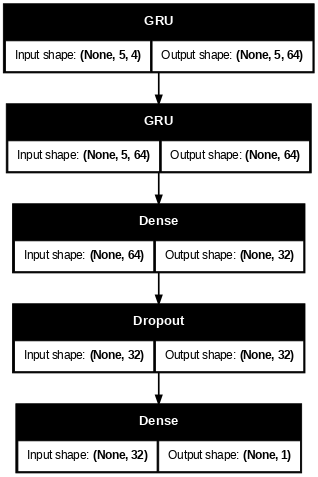

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=60)

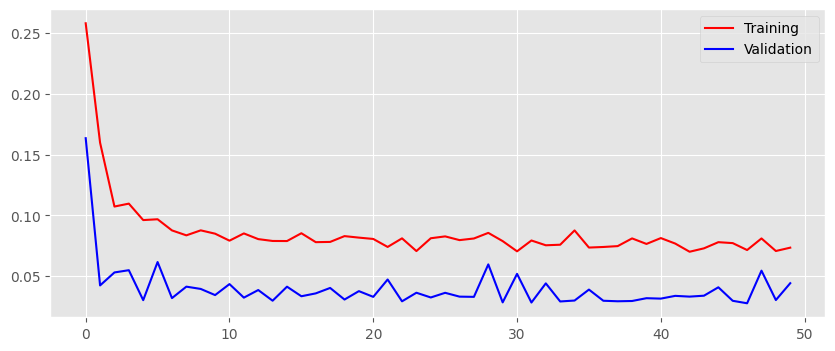

In [ ]:
# Plot the MAE for both the training and validation samples
plt.style.use('ggplot')
plt.figure(figsize=(10, 4))
plt.plot(history.history['mean_absolute_error'],c="r")
plt.plot(history.history['val_mean_absolute_error'],c="b")
plt.legend(['Training','Validation'])
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
RMSE: 20.179523311120747
MAE: 14.03721055828157
R2: 0.8909976035349474


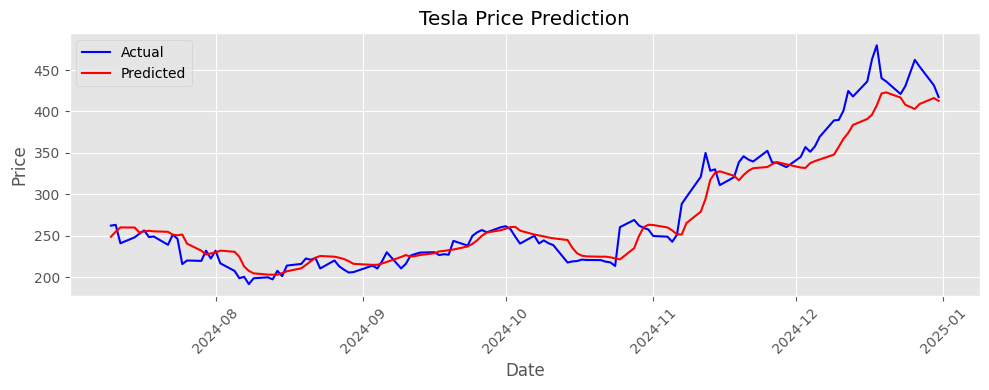

In [ ]:
# Predict the test set and unscale the values in order to graph our results
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Store our target metrics
rmse = np.sqrt(mean_squared_error(y_pred_inv, y_test_inv))
mae = mean_absolute_error(y_pred_inv, y_test_inv)
r2 = r2_score(y_pred_inv, y_test_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

result_df = pd.DataFrame({
    'Date': test_df.iloc[time_steps + target_offset + target_length - 1 : time_steps + target_offset + target_length - 1 + len(y_pred_inv)]['Date'].values,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

# Plot the prediccted versus the actual stock price for the test range
plt.figure(figsize=(10, 4))
plt.plot(result_df['Date'], result_df['Actual'], label='Actual', color='blue')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted', color='red')
plt.title('Tesla Price Prediction')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The following testing version is the same as above. The only difference is that we are are graphing the open, high and low for the day to see if our model is close to these values. Although our model is not designed to be predicting these, we were interested to compare the output to something else beyond the naive model.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
RMSE: 20.179523311120747
MAE: 14.03721055828157
R2: 0.8909976035349474


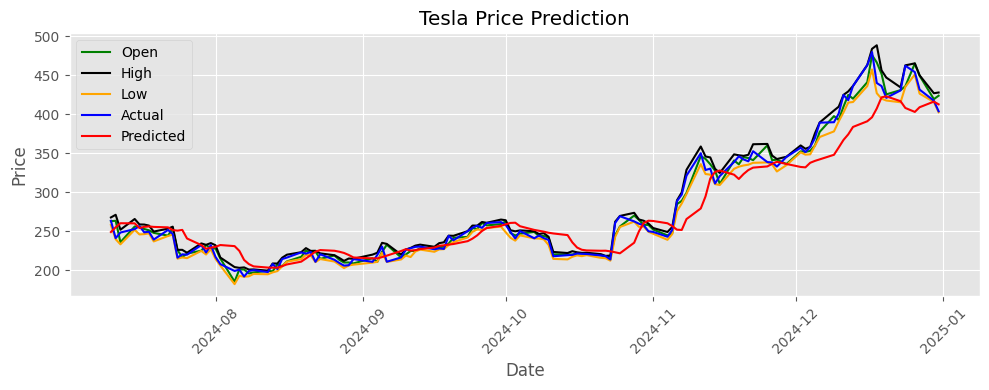

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_pred_inv, y_test_inv))
mae = mean_absolute_error(y_pred_inv, y_test_inv)
r2 = r2_score(y_pred_inv, y_test_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

start_idx = time_steps + target_offset + target_length -1
end_idx = start_idx + len(y_pred_inv)

result_df = pd.DataFrame({
    'Date': test_df.iloc[start_idx : end_idx]['Date'].values,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

plt.figure(figsize=(10, 4))
plt.plot(result_df['Date'], test_df.iloc[start_idx:end_idx]['Open'].values, label='Open', color='green')
plt.plot(result_df['Date'], test_df.iloc[start_idx:end_idx]['High'].values, label='High', color='black')
plt.plot(result_df['Date'], test_df.iloc[start_idx:end_idx]['Low'].values, label='Low', color='orange')
plt.plot(result_df['Date'], test_df.iloc[start_idx:end_idx]['Close'].values, label='Actual', color='blue')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted', color='red')
plt.title('Tesla Price Prediction')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Multimodal

In this attempt, we incorporated text data with stock data. To achieve this, we created a multimodal model that uses both types of input (two branches) to predict the numerical 'close' stock price.

In this effort, we tokenized the text data using a vocabulary size of 10,000 words and embedded it into 200-dimensional vectors with the Tokenizer from tensorflow.keras.preprocessing.text.

Additionally, we used combined information from all companies, based on the hypothesis that this would improve performance by allowing the model to learn the general market trends.

In [ ]:
test_stock_df = df_stocks_final[df_stocks_final['Date'] >= '2024-06-01'].reset_index(drop=True)
train_stock_df = df_stocks_final[df_stocks_final['Date'] < '2024-06-01'].reset_index(drop=True)

test_text_df = text_filtered_days[text_filtered_days['Date'] >= '2024-06-01'].reset_index(drop=True)
train_text_df = text_filtered_days[text_filtered_days['Date'] < '2024-06-01'].reset_index(drop=True)

In [ ]:
# All features from our dataset that were used in our training
feature_cols=['Close', 'High', 'Low', 'Open']

# MinMax to ensure that higher values from our numerical data does not have a higher importance than the lower ones
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_stock_df[feature_cols])

target_scaler = MinMaxScaler()
target_scaler.fit(train_stock_df[['Close']])

MinMaxScaler()

In [ ]:
# Create sequences for stock prices (price sequences for time_steps)
X_all = []
y_all = []

for ticker in df_stocks_final['Company'].unique():
    X, y = price_sequences(train_stock_df, ticker, time_steps=5, feature_scaler=feature_scaler, target_scaler=target_scaler, target_column='Close')
    X_all.append(X)
    y_all.append(y)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

# Apply the function to create the news sequences
news_sequences_results = news_sequences(train_text_df, time_steps=5)

# Parameters
max_length = 200
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(news_sequences_results)

# Convert the sequences to tokenized and padded sequences
news_sequences_tokenized = tokenizer.texts_to_sequences(news_sequences_results)
padded_sequences = pad_sequences(news_sequences_tokenized, maxlen=max_length, padding='post', truncating='post')

# Ensure that `X_all` and `padded_sequences` have the same length
assert X_all.shape[0] == padded_sequences.shape[0], "The lengths of X_all and padded_sequences do not match!"

print(f"X_all Shape: {X_all.shape}")
print(f"padded_sequences Shape: {padded_sequences.shape}")

X_all Shape: (2450, 5, 4)
padded_sequences Shape: (2450, 200)


In [ ]:
max_length = 200       # Maximum length for text sequences
vocab_size = 10000     # Vocabulary size
embedding_dim = 32     # Dimension for embedding layer
time_steps = 5         # Length of historical window for stock prices
n_features = 4         # Number of features in stock data (for example: Open, High, Low, Close)
num_samples = 500      # Number of synthetic data samples


# Text branch
text_input = Input(shape=(max_length,), name='news_text_input')
embedded_text = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='text_embedding')(text_input)
embedded_text = Dropout(0.2)(embedded_text)
text_features = LSTM(64, name='text_lstm')(embedded_text)
text_features = Dense(32, activation='relu', name='text_dense')(text_features)

# Stock price branch
price_input = Input(shape=(time_steps, n_features), name='price_input')
price_features = LSTM(64, name='price_lstm')(price_input)
price_features = Dense(32, activation='relu', name='price_dense')(price_features)

# Merge branches
merged = Concatenate(name='feature_concatenation')([text_features, price_features])
merged_dense = Dense(64, activation='relu', name='merged_dense1')(merged)
merged_dense = Dense(32, activation='relu', name='merged_dense2')(merged_dense)

# Output layer for regression (predicting a continuous stock price)
output = Dense(1, activation='linear', name='output')(merged_dense)

# Build and compile the model
model = Model(inputs=[text_input, price_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mean_absolute_error"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(x={'news_text_input': padded_sequences, 'price_input': X_all},
                     y=y_all,
                     epochs=50, batch_size=50, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0684 - mean_absolute_error: 0.1802 - val_loss: 6.5919e-04 - val_mean_absolute_error: 0.0205
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.6182e-04 - mean_absolute_error: 0.0145 - val_loss: 3.1950e-04 - val_mean_absolute_error: 0.0133
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2534e-04 - mean_absolute_error: 0.0079 - val_loss: 3.3909e-04 - val_mean_absolute_error: 0.0135
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5067e-04 - mean_absolute_error: 0.0078 - val_loss: 3.2134e-04 - val_mean_absolute_error: 0.0132
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3160e-04 - mean_absolute_error: 0.0075 - val_loss: 3.0760e-04 - val_mean_absolute_error: 0.0128
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2299e-04 - mean_absolute_error: 0.0074 - val_loss: 3.2892e-04 - val_mean_absolute_error: 0.0132
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2

In [ ]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ news_text_input     │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 200, 32)   │    320,000 │ news_text_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 32)   │          0 │ text_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_input         │ (None, 5, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_lstm (LSTM)    │ (None, 64)        │     24,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_lstm (LSTM)   │ (None, 64)        │     17,664 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dense (Dense)  │ (None, 32)        │      2,080 │ text_lstm[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_dense (Dense) │ (None, 32)        │      2,080 │ price_lstm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concatenat… │ (None, 64)        │          0 │ text_dense[0][0], │
│ (Concatenate)       │                   │            │ price_dense[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense1       │ (None, 64)        │      4,160 │ feature_concaten… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense2       │ (None, 32)        │      2,080 │ merged_dense1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ merged_dense2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 372,929 (1.42 MB)

 Trainable params: 372,929 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

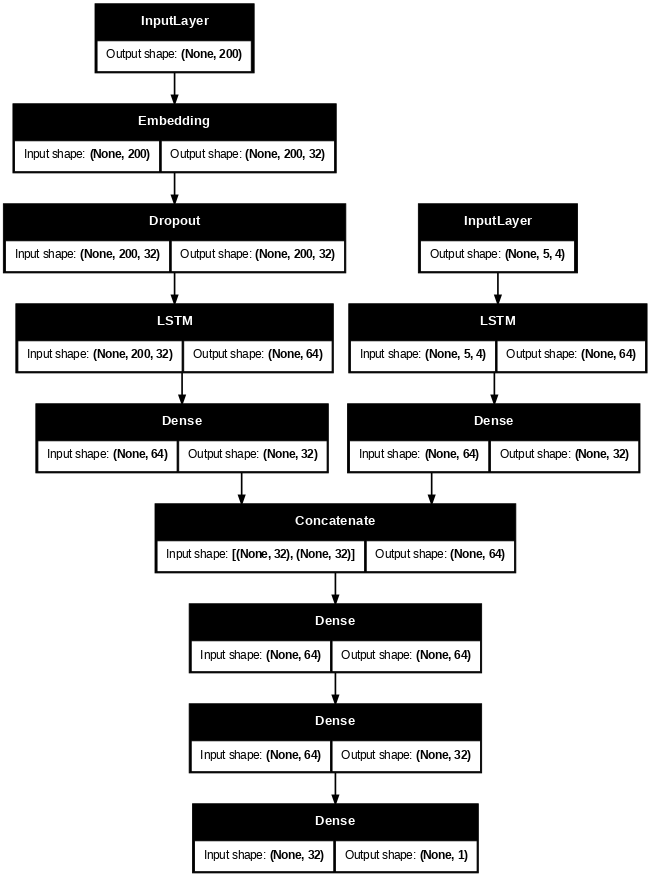

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=60)

In [ ]:
history_dict = history.history

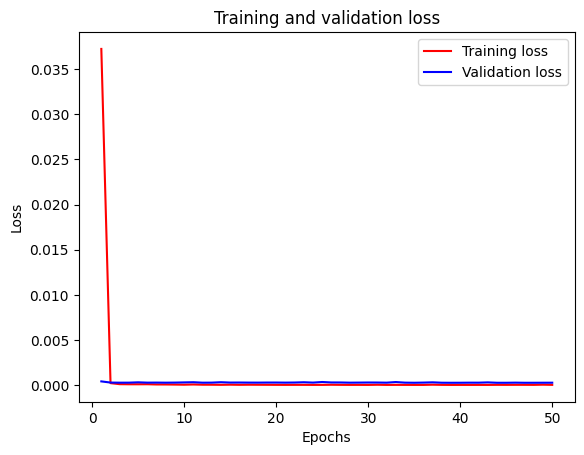

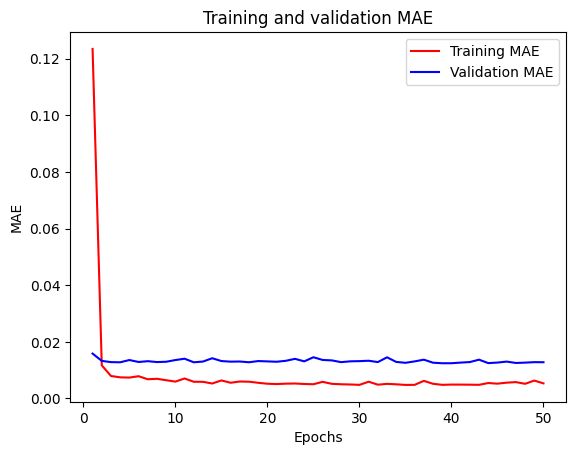

In [ ]:
# Plotting the loss
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the MAE
mse = history_dict["mean_absolute_error"]
val_mse = history_dict["val_mean_absolute_error"]
plt.plot(epochs, mse, "r", label="Training MAE")
plt.plot(epochs, val_mse, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
tesla = test_text_df[test_text_df['Company']=='Tesla']

X_all = []
y_all = []

for ticker in ['Tesla']:
    X, y = price_sequences(test_stock_df, ticker, time_steps=5, feature_scaler=feature_scaler, target_scaler=target_scaler, target_column='Close')
    X_all.append(X)
    y_all.append(y)

X_all_test = np.concatenate(X_all)
y_all_test = np.concatenate(y_all)

news_sequences_results = news_sequences(tesla, time_steps=5)

max_length = 200
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(news_sequences_results)

news_sequences_tokenized = tokenizer.texts_to_sequences(news_sequences_results)
padded_sequences_test = pad_sequences(news_sequences_tokenized, maxlen=max_length, padding='post', truncating='post')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 16.6800
MAE: 12.4327
R²: 0.9513


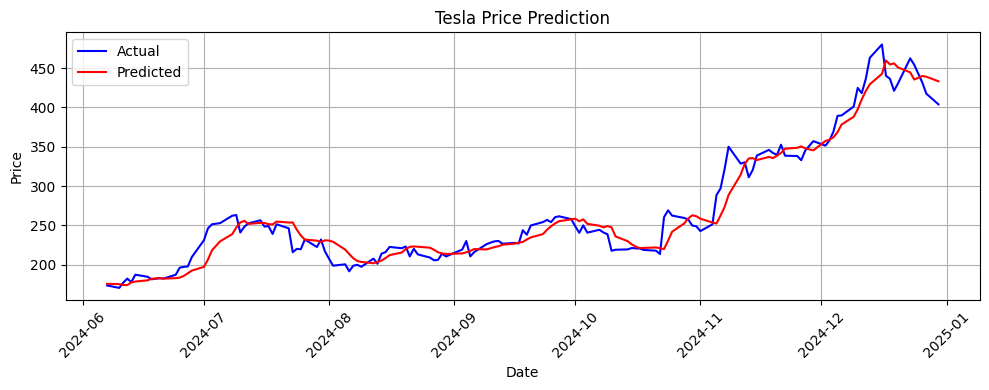

In [ ]:
# Predict with the multimodal model
y_pred = model.predict({
    'news_text_input': padded_sequences_test,
    'price_input': X_all_test
})

# Inverse-transform predictions and true values if a scaler was used
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_all_test.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

tesla = test_stock_df[test_stock_df['Company']=='Tesla']
result_df = pd.DataFrame({
    'Date': tesla.iloc[time_steps + - 1 : time_steps - 1 + len(y_pred_inv)]['Date'].values,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

plt.figure(figsize=(10, 4))
plt.plot(result_df['Date'], result_df['Actual'], label='Actual', color='blue')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted', color='red')
plt.title('Tesla Price Prediction')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We have improved our results compared to the previous GRU model. However, we believe that further improvements are possible by enhancing our text preprocessing. For example, we think that by using a pretrained model to better capture the sentiment of the text is a better solution.

## FinBERT

After constructing a unified dataset that merges FinBERT-based news sentiment with historical stock price data, the next step is to model the relationship between public sentiment and stock market behavior. Our goal is to predict the daily closing price of a company's stock by incorporating both quantitative financial indicators and qualitative sentiment signals. To do this, we use a neural network that can handle multiple input types (numerical and categorical) reflecting the hybrid nature of our dataset.

In [ ]:
## Load tokenizer and model
#tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
#model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# Build pipeline with truncation and padding enabled
#finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, truncation=True, padding=True)

In [ ]:
from tqdm import tqdm

# Store results
#sentiment_labels = []
#sentiment_scores = []

# Use tqdm for progress bar
#for text in tqdm(news_df_bert['body_clean']):
#    try:
#        result = finbert(text[:512])[0]  # [:512] is a safe fallback, tokenizer will truncate anyway
#        sentiment_labels.append(result['label'])
#        sentiment_scores.append(result['score'])
 #   except:
  #      sentiment_labels.append('ERROR')
   #     sentiment_scores.append(0.0)


In [ ]:
#news_df_bert['sentiment_label'] = sentiment_labels
#news_df_bert['sentiment_score'] = sentiment_scores

In [ ]:
news_df_bert['Date_day'] = pd.to_datetime(news_df_bert['Date_day'])

news_df_bert = news_df_bert.rename(columns={'matched_company': 'Company', 'Date_day':'Date'})

NameError: name 'pd' is not defined

In [ ]:
news_tsla = news_df_bert[news_df_bert['Company'] == 'Tesla'].reset_index(drop=True)
news_goog = news_df_bert[news_df_bert['Company'] == 'Alphabet'].reset_index(drop=True)
news_amzn = news_df_bert[news_df_bert['Company'] == 'Amazon'].reset_index(drop=True)
news_aapl = news_df_bert[news_df_bert['Company'] == 'Apple'].reset_index(drop=True)
news_meta = news_df_bert[news_df_bert['Company'] == 'Meta'].reset_index(drop=True)
news_msft = news_df_bert[news_df_bert['Company'] == 'Microsoft'].reset_index(drop=True)
news_nvda = news_df_bert[news_df_bert['Company'] == 'NVIDIA'].reset_index(drop=True)

In [ ]:
news_dict = {
    'Apple': news_aapl,
    'Amazon': news_amzn,
    'Alphabet': news_goog,
    'Meta': news_meta,
    'Microsoft': news_msft,
    'NVIDIA': news_nvda,
    'Tesla': news_tsla
}

stock_dict = {
    'Apple': df_apple,
    'Amazon': df_amazon,
    'Alphabet': df_alphabet,
    'Meta': df_meta,
    'Microsoft': df_microsoft,
    'NVIDIA': df_nvidia,
    'Tesla': df_tesla
}

sentiment_dict = {}

for ticker in news_dict.keys():
    merged_df = pd.merge(
        news_dict[ticker][['Date', 'Company', 'sentiment_label', 'sentiment_score']],
        stock_dict[ticker][['Date', 'Company', 'Open', 'High', 'Low', 'Close', 'Volume']],
        left_on=['Date', 'Company'],
        right_on=['Date', 'Company'],
        how='inner'
    )


    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    merged_df.set_index('Date', inplace=True)
    merged_df.sort_index(inplace=True)

    sentiment_dict[ticker] = merged_df
    globals()[f"sentiment_{ticker.lower()}"] = merged_df


In the final phase, While the merged dataset includes a range of numerical features such as Open, High, Low, Close, and Volume, we selectively focus on just two high-impact predictors: the Open price (as a baseline financial input) and the FinBERT sentiment score (capturing real-time market perception). Additionally, we include the sentiment label (Positive, Neutral, Negative) as a separate categorical input to allow the model to distinguish sentiment direction. The data is then split chronologically: training data up to the end of 2023, validation for the first half of 2024, and testing from July 2024 onward.


📈 Training model for: Apple
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Apple - MAE: 4.82, RMSE: 5.52, R²: 0.73


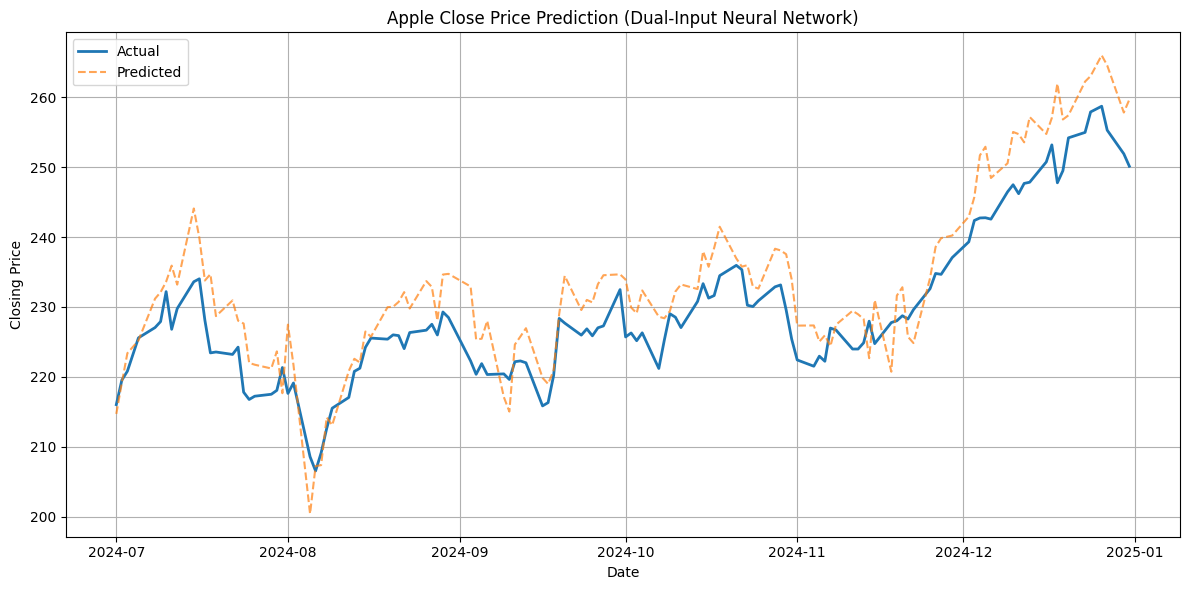


📈 Training model for: Amazon
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Amazon - MAE: 3.58, RMSE: 4.42, R²: 0.94


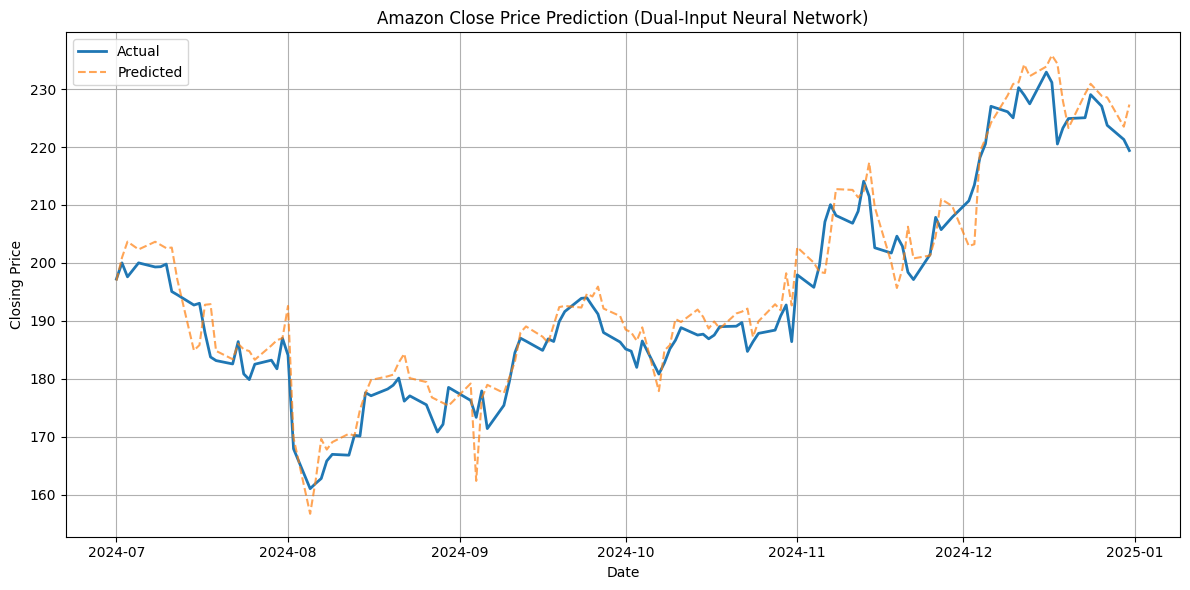


📈 Training model for: Alphabet
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
Alphabet - MAE: 3.19, RMSE: 3.82, R²: 0.89


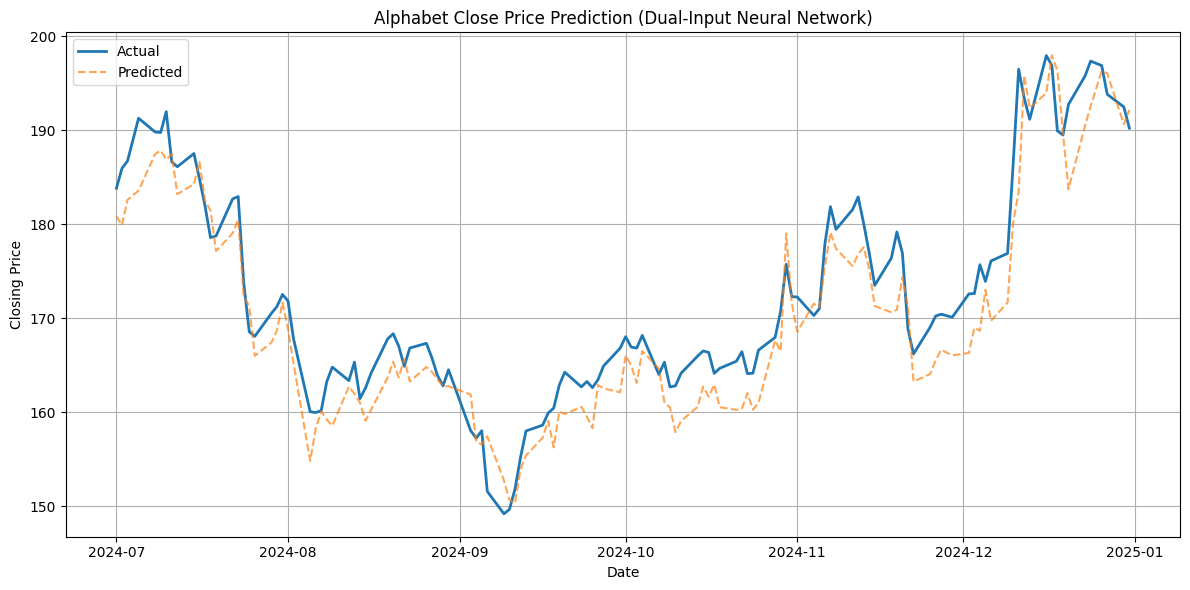


📈 Training model for: Meta
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Meta - MAE: 15.98, RMSE: 20.23, R²: 0.79


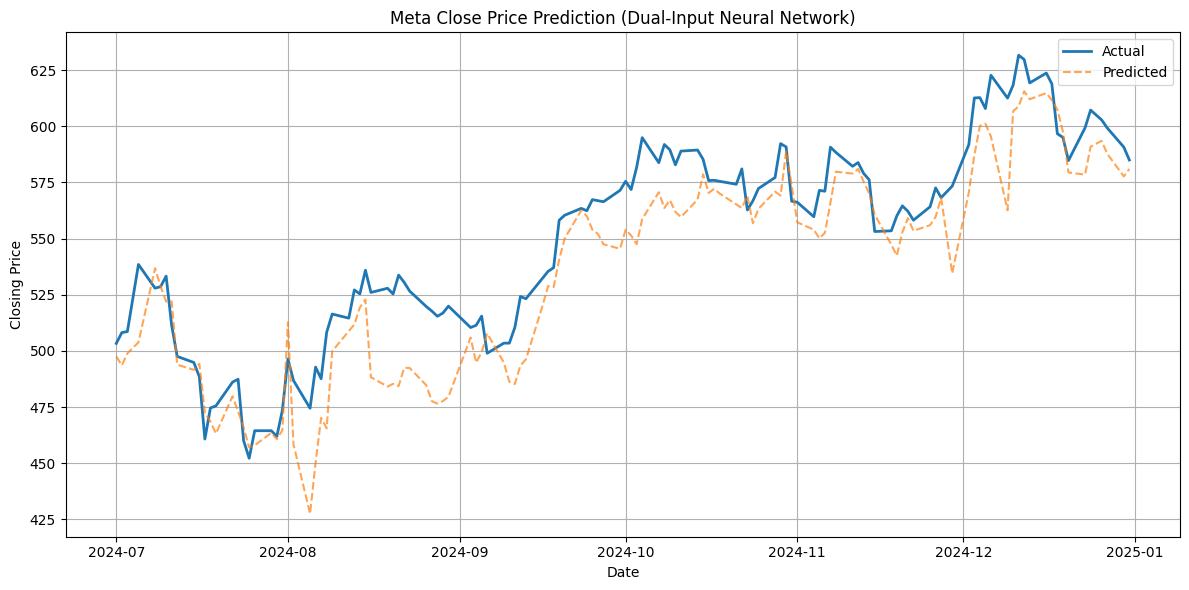


📈 Training model for: Microsoft
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Microsoft - MAE: 3.86, RMSE: 4.86, R²: 0.90


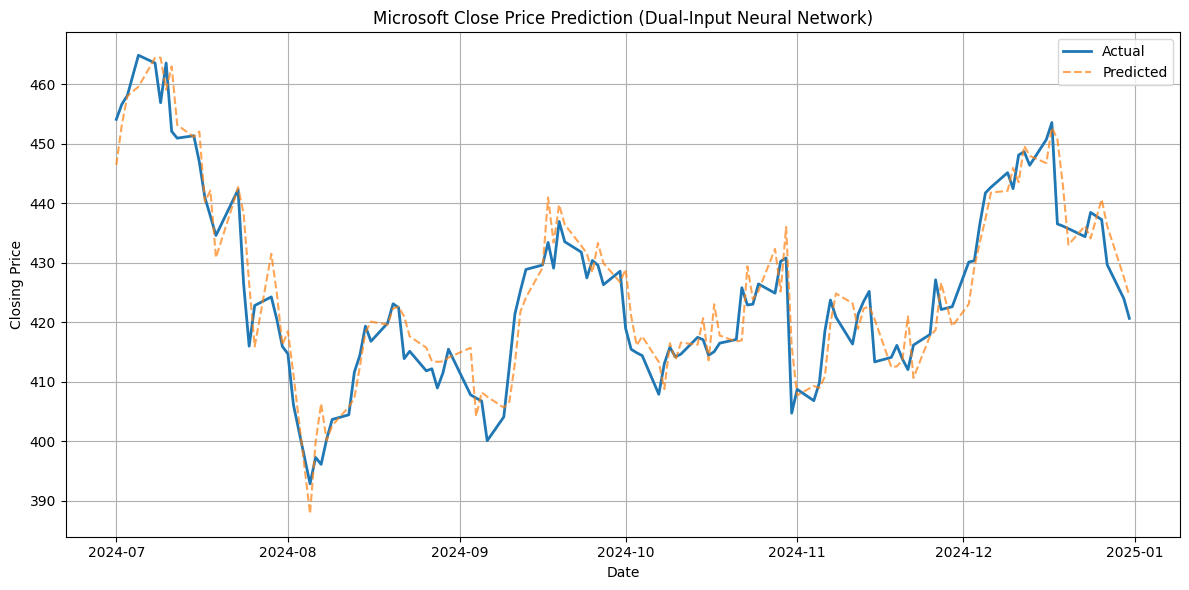


📈 Training model for: NVIDIA
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
NVIDIA - MAE: 3.84, RMSE: 4.51, R²: 0.87


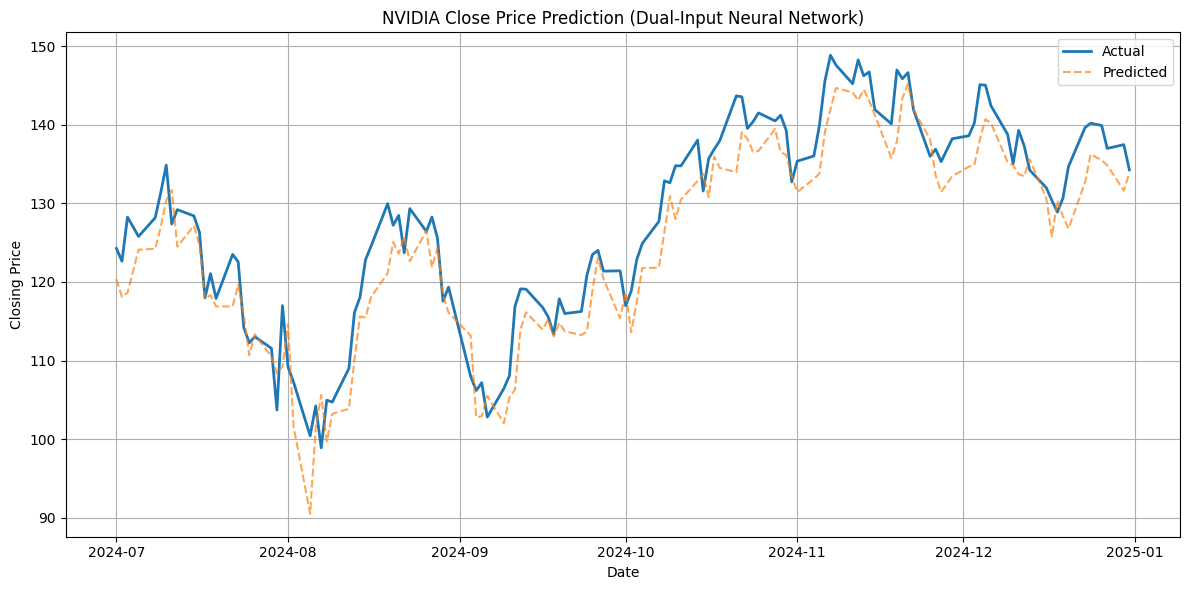


📈 Training model for: Tesla
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Tesla - MAE: 7.61, RMSE: 10.16, R²: 0.98


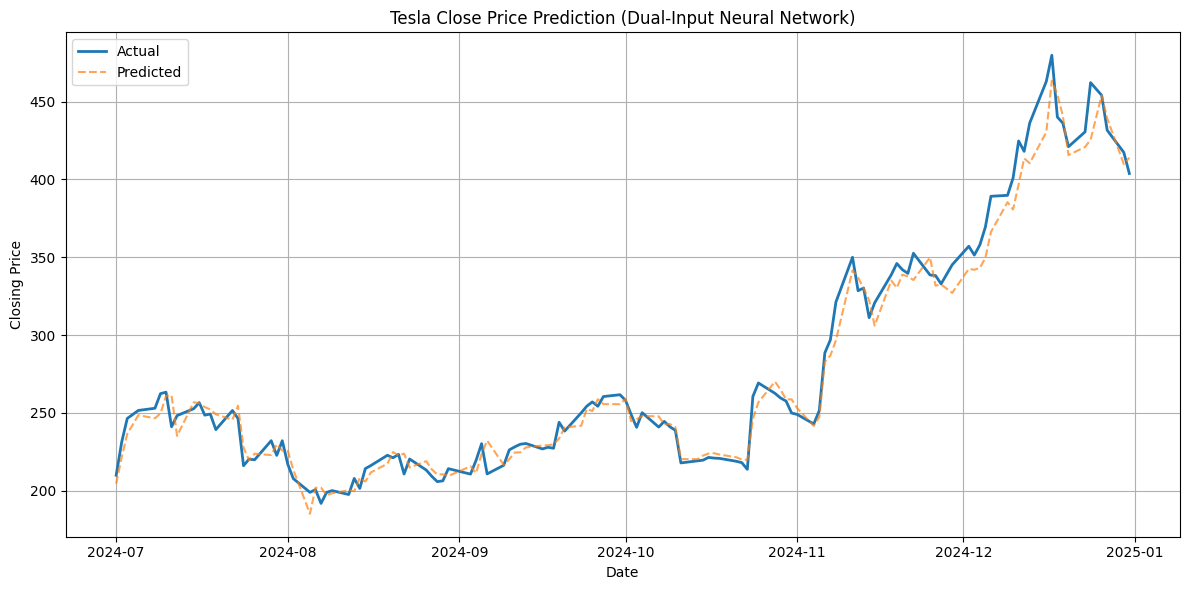


📊 Model Performance Summary:


,Ticker,MAE,RMSE,R2
2,Alphabet,3.189210,3.819399,0.890981
1,Amazon,3.584157,4.421906,0.935622
5,NVIDIA,3.839326,4.511712,0.870302
4,Microsoft,3.857760,4.864260,0.899663
0,Apple,4.815434,5.520112,0.729219
6,Tesla,7.610059,10.160799,0.981303
3,Meta,15.982007,20.231367,0.788902


In [ ]:
num_features = ['sentiment_score', 'Open']
cat_feature = 'sentiment_label_encoded'
target = 'Close'

results_list = []

for ticker, sentiment_df in sentiment_dict.items():
    print(f"\n📈 Training model for: {ticker}")


    label_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    sentiment_df['sentiment_label_encoded'] = sentiment_df['sentiment_label'].map(label_map)

    X_num = sentiment_df[num_features]
    X_cat = sentiment_df[[cat_feature]]
    y = sentiment_df[target]

    scaler = MinMaxScaler()
    X_num_scaled = scaler.fit_transform(X_num)

    train_idx = sentiment_df.index <= '2023-12-31'
    val_idx = (sentiment_df.index >= '2024-01-01') & (sentiment_df.index <= '2024-06-30')
    test_idx = sentiment_df.index >= '2024-07-01'

    X_num_train, X_num_val, X_num_test = X_num_scaled[train_idx], X_num_scaled[val_idx], X_num_scaled[test_idx]
    X_cat_train, X_cat_val, X_cat_test = X_cat[train_idx], X_cat[val_idx], X_cat[test_idx]
    y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

    input_num = Input(shape=(X_num_train.shape[1],))
    x = Dense(64, activation='relu')(input_num)
    x = Dense(32, activation='relu')(x)

    input_cat = Input(shape=(1,))
    y_cat = Dense(8, activation='relu')(input_cat)

    combined = Concatenate()([x, y_cat])
    z = Dense(32, activation='relu')(combined)
    output = Dense(1)(z)

    model = Model(inputs=[input_num, input_cat], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


    history = model.fit([X_num_train, X_cat_train], y_train,
                        validation_data=([X_num_val, X_cat_val], y_val),
                        epochs=100, batch_size=16, verbose=0)


    y_pred = model.predict([X_num_test, X_cat_test]).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{ticker} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--', alpha=0.7)
    plt.title(f'{ticker} Close Price Prediction (Dual-Input Neural Network)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    results_list.append({
        'Ticker': ticker,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

results_df = pd.DataFrame(results_list)
print("\n📊 Model Performance Summary:")
display(results_df.sort_values(by='MAE'))


# Moving Forward

To improve the predictive performance of our stock price model, we should consider incorporating a broader and more diverse dataset in terms of financial ratios, components, etc. Extending the historical time frame of our analysis can provide the model with more context and better capture long term trends. Additionally, enhancing the diversity and reliability of the textual data, such as financial news, earnings reports, or social media sentiment, can enrich the model's understanding of market dynamics. Also, given that high frequency trading operates on the scale of milliseconds and seconds, our current daily level prediction may overlook important intraday patterns. Therefore, transitioning to a shorter prediction window, such as minute or hourly forecasts, could yield more actionable insights. We would like to get to the same level of granularity as hedge funds, but we do not have the same access to data that these places do. From a financial metrics perspective, targeting returns rather than raw prices could improve model stability, as returns are typically more stationary. Lastly, incorporating additional financial indicators, such as volatility measures, technical ratios, and macroeconomic variables, may further enhance the model’s ability to predict stock movements effectively.